# Feature selection for water shortage

Import libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler

Calculate the new variables, divide the water shortage indicator into 4 risk levels

In [59]:
data=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/preprocessed+data.csv')
data=data.set_index(['Area','Year'])
#data['% of total country area irrigated (%)']=data['% of total country area cultivated']*data['% of cultivated land irrigated [harvested crop]']/100
data['Industry, value added (% GDP)']=data['Industry, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['Services, value added (% GDP)']=data['Services, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['water resource per capita']=data['Total renewable water resources per capita']-data['Environmental Flow Requirements']
data['shortageclass'] = pd.cut(data['water resource per capita'],bins=[0,500,1000,1700,240000],labels=['3','2','1','0'])

In [60]:
data.head()

Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

                    Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

                    Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

                    Industry, value added to GDP  \
Area        Year                                   
Afghanistan 1992.0                  5.530000e+08   
            1997.0                  4.220000e+08   
            2002.0                  9.150000e+08   
            2007.0                  2.600000e+09   
            2012.0                  4.360000e+09   

                    Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

                    MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

                    National Rainfall Index (NRI)  Population density  ...  \
Area        Year                                                       ...   
Afghanistan 1992.0                         304.98           22.187829  ...   
            1997.0                         233.00           29.649735  ...   
            2002.0                         185.00           34.618096  ...   
            2007.0                         185.00           41.510486  ...   
            2012.0                         185.00           47.730564  ...   

                    SDG 6.4.2. Water Stress  Services, value added to GDP  \
Area        Year                                                            
Afghanistan 1992.0                63.337788                  9.950000e+08   
            1997.0     

## Data Preprocessing and exploration


In [61]:
print(data['water resource per capita'].describe())

count       259.000000
mean      21141.243523
std       40411.946627
min         211.751182
25%        1548.433426
50%        3509.947955
75%       20863.763420
max      235263.846100
Name: water resource per capita, dtype: float64


the distribution of water shortage index

<AxesSubplot:>

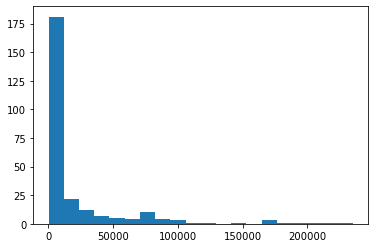

In [62]:
data['water resource per capita'].hist(grid=False, bins=20)

right skewed

dichotomization:

water shortage: water resource per capita<1700 m^3 per person per year

## Classification

In [63]:
X=data.iloc[:,0:23].drop(
    ['Environmental Flow Requirements',
     'Total renewable water resources per capita',
    'Industry, value added to GDP',
    'Services, value added to GDP',
     'water resource per capita'],axis=1)
y=data['shortageclass']

In [64]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=0,shuffle=True,stratify=y)

In [65]:
#scaler = StandardScaler()

In [66]:
#X_train_scaled = scaler.fit_transform(X_train)

In [67]:
#X_test_scaled = scaler.transform(X_test)

## Create pipeline framework

In [68]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('selector', SelectKBest(mutual_info_classif, k=5)),
                 ('classifier', LogisticRegression())])

#pipe = Pipeline([('selector', SelectKBest()),
                 #('classifier', KNeighborsClassifier(leaf_size=5,n_neighbors=15))])
#param_grid = [{'selector__k': [ 5, 6, 7, 8, 9, 10]}]

#grid = GridSearchCV(pipe, param_grid, cv=5)
#grid.fit(X_train_scaled, y_train)

#k=grid.best_params_['selector__k']
#print("Best params:\n{}\n".format(grid.best_params_))
#print("Best cross-validation score: {:.2f}".format(grid.best_score_))
#print(grid.best_estimator_)

## Create search space


In [69]:
search_space = [{'selector__k': [5, 6, 7, 8, 9, 10]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators':[30, 50, 100],
                 'classifier__max_features': [1, 2, 3],
                 'classifier__min_samples_leaf':[1, 2, 3]},
                {'classifier': [LogisticRegression(max_iter=7000)]},
                {'classifier': [naive_bayes.GaussianNB()]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__leaf_size': [5,10,15,30],
                 'classifier__n_neighbors': [5,10,15]}]

## model selection

In [70]:
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train)



best_pipe=clf.best_estimator_
features = best_pipe.named_steps['selector']


In [71]:
print("Best params:\n{}\n".format(clf.best_params_))
print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best estimator:\n{}\n".format(clf.best_estimator_))
print("Selected features:\n{}\n".format(X.columns[features.get_support()]))

Best params:
{'classifier': RandomForestClassifier(max_features=1, n_estimators=30), 'classifier__max_features': 1, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 30}

Best cross-validation score: 0.95
Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x7fbbd9c3cc10>)),
                ('classifier',
                 RandomForestClassifier(max_features=1, n_estimators=30))])

Selected features:
Index(['Agricultural water withdrawal as % of total renewable water resources',
       'Long-term average annual precipitation in volume',
       'MDG 7.5. Freshwater withdrawal as % of total renewable water resources',
       'National Rainfall Index (NRI)', 'SDG 6.4.2. Water Stress'],
      dtype='object')

